#**Important Note:**

This Colab notebook provides an overview of the code used in the app.


1. The app is the primary tool for performing bacterial colony analysis. Typically, it takes around 5–15 minutes to process an image, though some images—especially those with a large number of colonies—may take longer.

2. If the app encounters memory issues, you can use this Colab notebook as an alternative to obtain your results.

3. Some package versions may differ between the Colab environment and the app (e.g., Streamlit may not support the latest versions of certain libraries). As a result, there might be slight variations in the output between the app and the notebook.

4. **Section 2** is the most important section where you upload your image and then run the subsequent sections to get the results.

5. **Section 3** asks for the name of your image file. If Section 2 says:
Saving G22_Day_1.jpg to G22_Day_1 (1).jpg,
then the correct filename to use in Section 3 is: G22_Day_1 (1).jpg (the later one).

# **Bacterial Colony Detection: Image Analysis Pipeline**

###Bacterial colony counting and characterization is a fundamental task in microbiology. Manual analysis of Petri dish images is time-consuming and prone to error, especially when dealing with large datasets or high-throughput experiments. This notebook guides you through a complete, 12-step workflow for analyzing photographs of Petri dishes with bacterial colonies:

###**Section 1: Prepares the Environment**  
Installs and imports all necessary image-processing and data-analysis libraries.

###**Section 2: Loads Your Image**  
Lets you upload a dish photograph via a file picker.

###**Section 3: Displays the Image**  
Shows the loaded photograph and prints basic properties (dimensions, color channels) so you can confirm it loaded correctly.

###**Section 4: Cleans and Enhances Image**  
Applies noise reduction and contrast enhancement so plate edges and colonies stand out.

###**Section 5: Detects the Plate**  
Locates the inner region of the Petri dish and creates a binary mask of the plate area.

###**Section 6: Segments Colonies**  
Uses adaptive thresholding, morphology, and watershed (or connected components) to separate each colony into its own labeled region.

###**Section 7: Analyzes Shape (Morphology)**  
Measures size, roundness, elongation, solidity, and classifies edge style and form for every colony.

###**Section 8: Extracts and Clusters Color**  
Finds each colony’s dominant hue, converts to Lab color space, and groups similar-looking colonies.

###**Section 9: Quantifies Density & Opacity**  
Computes brightness, texture, and saturation metrics to classify how “dense” or “translucent” each colony appears.

###**Section 10: Computes Combined Scores**  
Merges shape, color, and density features into a single “interest” score, highlighting the most distinctive colonies.

###**Section 11: Visualizes Top Colonies**  
Draws outlines on the full dish and generates zoomed-in panels of the highest-scoring colonies for easy inspection.

###**Section 12: Alternate Binary/Grid View**  
Presents a black-and-white mask with grid overlays and zoomed crops of top colonies for precise size reference.

---

###**Inputs:**  
- A single high-resolution Petri-dish image (JPEG/PNG).  
- Optional parameters (e.g., number of top colonies to display, threshold settings).

###**Outputs:**  
- Cleaned and masked images.  
- Tables of per-colony morphology, color, density, and combined scores.  
- Visual overlays and zoomed panels of top-ranked colonies.

###We can use this modular pipeline to quickly identify and characterize interesting bacterial colonies from petri dish images.


## **Section 1: Environment Setup and Dependencies**
### This section installs and imports all necessary libraries for image processing, clustering, visualization, and scientific computation.

In [ ]:
#Section 1: Environment Setup and Dependencies

# Goal: Prepare Python with all Required Libraries, we are mainly making use of OpenCV and scikit-image which are predefined python libraries for the

# Output: Imported Modules and Installed Packages



!pip install opencv-python scikit-image scikit-learn seaborn pandas matplotlib numpy scipy

import cv2
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans, DBSCAN
from scipy import ndimage
from skimage import filters, morphology, measure, segmentation
from skimage.feature import peak_local_max
import pandas as pd
import seaborn as sns
from concurrent.futures import ThreadPoolExecutor
import warnings
warnings.filterwarnings('ignore')

print("Setup complete")

Setup complete



## **Section 2**: **Uploading the Petri Dish Image**

###This section handles image upload via Colab's file picker.



In [ ]:
#Section 2: Uploading the Petri Dish Image

# Goal: Read the User’s Petri-Dish Image into Memory.
# Input: Uploaded Image Object.
# Output: processed_image as an RGB NumPy Array.


from google.colab import files
uploaded = files.upload()


Saving A5_Day_1.jpg to A5_Day_1.jpg


## **Section 3: Load and Display the Petri Dish Image**

### This section loads the uploaded Petri dish image and displays it along with basic image statistics.
### It also generates a histogram of pixel intensity values to help assess contrast and lighting uniformity.

###Key steps are:

### 1. Load the image using OpenCV
### 2. Convert it from BGR to RGB (since OpenCV loads in BGR format)
### 3. Display the original image using matplotlib
### 4. Plot a histogram showing the pixel intensity distribution

### Note: Make sure the image_path matches the filename of your uploaded image.

loading microbiome plate image
Image dimensions: 2581x2495, channels: 3


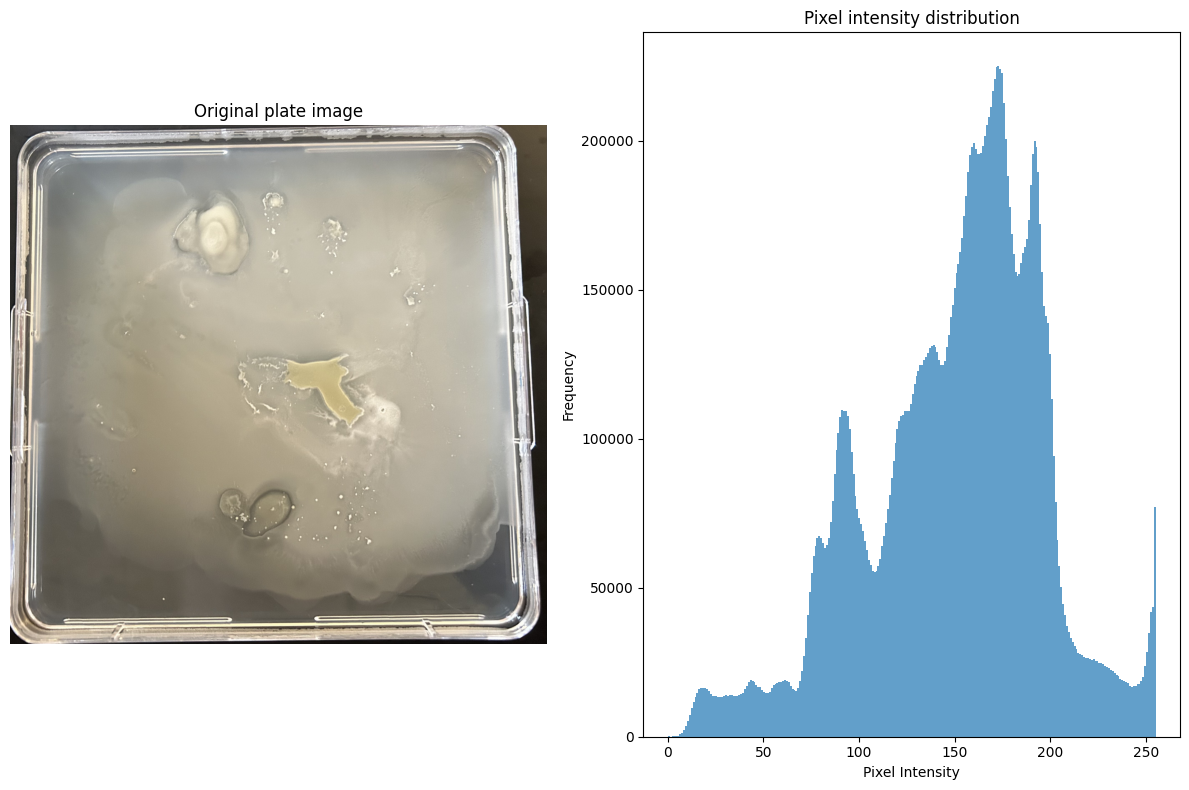

In [ ]:
#Section 3: Load and Display the Petri Dish Image

# Goal: Read the uploaded image file and show its basic properties.
# Input: `image_path` string.
# Output: `original_image` array, printed dimensions, and histogram.


import cv2
import numpy as np
import matplotlib.pyplot as plt

# load and display the microbiome plate image
# handles different image formats and shows original image

def load_and_display_image(image_path):
    print("loading microbiome plate image")

    # load image
    original_image = cv2.imread(image_path)
    if original_image is None:
        print("error loading image")
        return None

    original_image = cv2.cvtColor(original_image, cv2.COLOR_BGR2RGB)

    # display original image
    plt.figure(figsize=(12, 8))
    plt.subplot(1, 2, 1)
    plt.imshow(original_image)
    plt.title('Original plate image')
    plt.axis('off')

    # show image properties, image dimensions and channels
    h, w, c = original_image.shape
    print(f"Image dimensions: {w}x{h}, channels: {c}")

    plt.subplot(1, 2, 2)
    plt.hist(original_image.ravel(), bins=256, alpha=0.7)
    plt.title('Pixel intensity distribution')
    plt.xlabel('Pixel Intensity')
    plt.ylabel('Frequency')

    plt.tight_layout()
    plt.show()

    return original_image

#usage: this is just running your function to get the output

# Mention your filename here:

image_path = "A5_Day_1.jpg"  # change this to the exact name of image after upload (you can find the image name in the output of the section 2 : For example here, the correct filename would be the later one : Saving G22_Day_1.jpg to G22_Day_1 (1).jpg)
original_image = load_and_display_image(image_path)


##**Section 4: Image Preprocessing**

### Purpose :
### This section loads the uploaded Petri dish image and improves its quality to make downstream colony detection more accurate and robust.

### Key steps include:

### 1. Loading and displaying the original image
### 2. Noise reduction via bilateral filtering
### 3. Contrast enhancement using CLAHE
### 4. Gamma correction to brighten underexposed regions
### 5. Sharpening to highlight colony edges


Cleaning and enhancing image quality


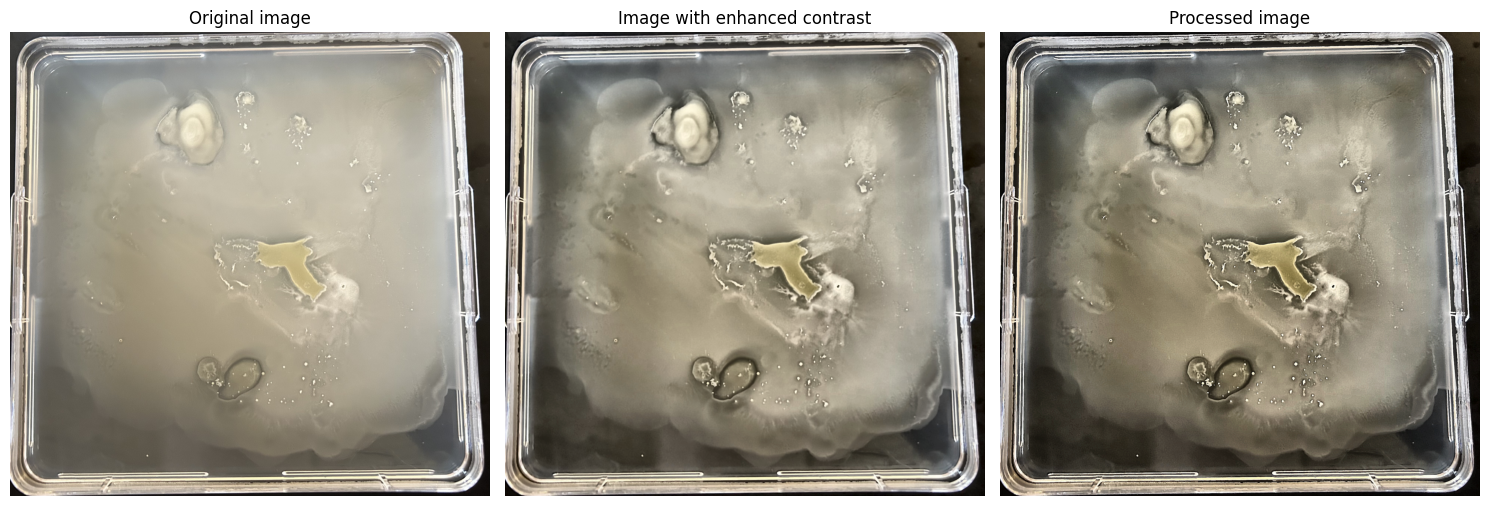

Preprocessing complete


In [ ]:
#Section 4: Image Preprocessing

# Goal: Denoise, enhance contrast, apply gamma correction, and sharpen the image.
# Input: `original_image`.
# Output: `processed_image` ready for segmentation.



def preprocess_plate_image(original_image):
    print("Cleaning and enhancing image quality")

    img = original_image.copy()

    # step 1: denoise while keeping edges sharp
    img_denoised = cv2.bilateralFilter(img, 9, 75, 75)

    # step 2: enhance contrast using CLAHE
    lab = cv2.cvtColor(img_denoised, cv2.COLOR_RGB2LAB)
    clahe = cv2.createCLAHE(clipLimit=3.0, tileGridSize=(8,8))
    lab[:,:,0] = clahe.apply(lab[:,:,0])
    img_enhanced = cv2.cvtColor(lab, cv2.COLOR_LAB2RGB)

    # step 3: gamma correction for better colony visibility
    gamma = 1.2
    img_gamma = np.power(img_enhanced / 255.0, gamma) * 255
    img_gamma = img_gamma.astype(np.uint8)

    # step 4: sharpen image slightly
    kernel = np.array([[-1,-1,-1], [-1,9,-1], [-1,-1,-1]])
    img_sharpened = cv2.filter2D(img_gamma, -1, kernel)

    # show before/after
    plt.figure(figsize=(15, 5))

    plt.subplot(1, 3, 1)
    plt.imshow(original_image)
    plt.title('Original image')
    plt.axis('off')

    plt.subplot(1, 3, 2)
    plt.imshow(img_enhanced)
    plt.title('Image with enhanced contrast')
    plt.axis('off')

    plt.subplot(1, 3, 3)
    plt.imshow(img_sharpened)
    plt.title('Processed image')
    plt.axis('off')

    plt.tight_layout()
    plt.show()

    print("Preprocessing complete")
    return img_sharpened

#usage: this is just running your function to get the output

processed_image = preprocess_plate_image(original_image)

### Image preprocessing is now complete! We can move to the plate detection next as we just want to include the plate in our further analysis.



## **Section 5: Plate Detection**

### This section isolates the inner plate area by excluding a small edge margin  
### It uses Otsu’s thresholding and contour analysis to refine the region into a binary mask  
### 1. Convert the preprocessed image to grayscale  
### 2. Define an inner rectangular margin and apply it to skip plate edges  
### 3. Apply Otsu’s thresholding to the masked grayscale image  
### 4. Find and fill the largest contour inside the inner mask  
### 5. Intersect the contour mask with the inner margin for the final mask  
### 6. Compute plate metrics (center, bounding box, area)  
### 7. Visualize original image, masks, and final result for verification  

  



Detecting inner plate area without edges
Inner plate area: 2169x2097, excluding 8.0% edge margin


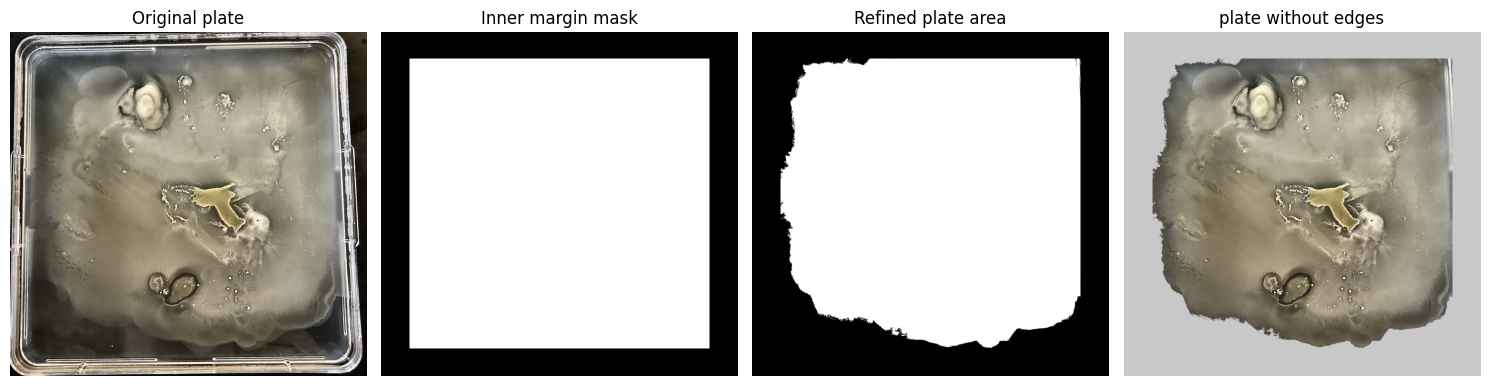

In [ ]:
#Section 5: Plate Detection

# Goal: Find the inner rectangular region of the plate and compute its metrics.
# Input: `processed_image`.
# Output: `plate_mask` and `plate_info` dict.


def improved_rect_plate_detection(processed_image):
    print("Detecting inner plate area without edges")

    gray = cv2.cvtColor(processed_image, cv2.COLOR_RGB2GRAY)
    h, w = gray.shape

    # create inner margin to exclude plate edges
    margin_percent = 0.08  # 8% margin from edges
    margin_h = int(h * margin_percent)
    margin_w = int(w * margin_percent)

    # create inner rectangular mask
    inner_mask = np.zeros((h, w), dtype=np.uint8)
    inner_mask[margin_h:h-margin_h, margin_w:w-margin_w] = 255

    # refine using intensity analysis
    masked_gray = cv2.bitwise_and(gray, gray, mask=inner_mask)

    # find the actual plate content area
    _, thresh = cv2.threshold(masked_gray, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)

    # find largest contour in the inner area
    contours, _ = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    if contours:
        largest_contour = max(contours, key=cv2.contourArea)
        refined_mask = np.zeros((h, w), dtype=np.uint8)
        cv2.fillPoly(refined_mask, [largest_contour], 255)

        # combine with inner margin
        final_mask = cv2.bitwise_and(inner_mask, refined_mask)
    else:
        final_mask = inner_mask

    # get bounding box info
    x, y, rect_w, rect_h = margin_w, margin_h, w-2*margin_w, h-2*margin_h

    plate_info = {
        'center': (w//2, h//2),
        'bbox': (x, y, rect_w, rect_h),
        'area_pixels': rect_w * rect_h,
        'inner_area': np.sum(final_mask > 0)
    }

    print(f"Inner plate area: {rect_w}x{rect_h}, excluding {margin_percent*100}% edge margin")

    # visualization
    plt.figure(figsize=(15, 4))

    plt.subplot(1, 4, 1)
    plt.imshow(processed_image)
    plt.title('Original plate')
    plt.axis('off')

    plt.subplot(1, 4, 2)
    plt.imshow(inner_mask, cmap='gray')
    plt.title('Inner margin mask')
    plt.axis('off')

    plt.subplot(1, 4, 3)
    plt.imshow(final_mask, cmap='gray')
    plt.title('Refined plate area')
    plt.axis('off')

    plt.subplot(1, 4, 4)
    result = processed_image.copy()
    result[final_mask == 0] = [200, 200, 200]  # gray out excluded areas
    plt.imshow(result)
    plt.title('plate without edges')
    plt.axis('off')

    plt.tight_layout()
    plt.show()

    return final_mask, plate_info

#usage: this is just running your function to get the output

plate_mask, plate_info = improved_rect_plate_detection(processed_image)

### Plate detection done – a rectangular mask has been generated using edge-based center estimation.
### We now have the plate's center, area, and the image is masked to exclude background.
### Next up: We'll use this mask to focus colony segmentation only inside the plate region.

## **Section 6: Colony Segmentation**

### This section segments bacterial colonies within the rectangular plate regions.  
### It uses adaptive thresholding (chooses a light/dark cutoff in small patches so colonies pop out even under uneven lighting), morphological cleaning (erases tiny specks and fills tiny holes to smooth shapes), and watershed (treats the image like a landscape so “water” can flow and split touching colonies) or connected components (just labels each separate white blob) to isolate individual colonies.

## Key steps:
### 1. Apply the plate mask to show only the plate area  
### 2. Convert to grayscale (shades of gray) and HSV (separates color from brightness)  
### 3. Use adaptive thresholding with binary inverse (local brightness cutoff turns colonies white, background black)  
### 4. Clean the mask: opening removes small dots, closing fills holes in colonies  
### 5. Compute distance transform (measures how far each pixel is from the background) to find colony centers  
### 6. Use watershed (imagine pouring water to divide touching blobs) or connected components if no clear centers  
### 7. Filter out blobs that are too small or too large to be real colonies  
### 8. Assign each valid colony a unique label and display the final result  


Segmenting colonies in rectangular plate
Found 1100 colonies in rectangular plate


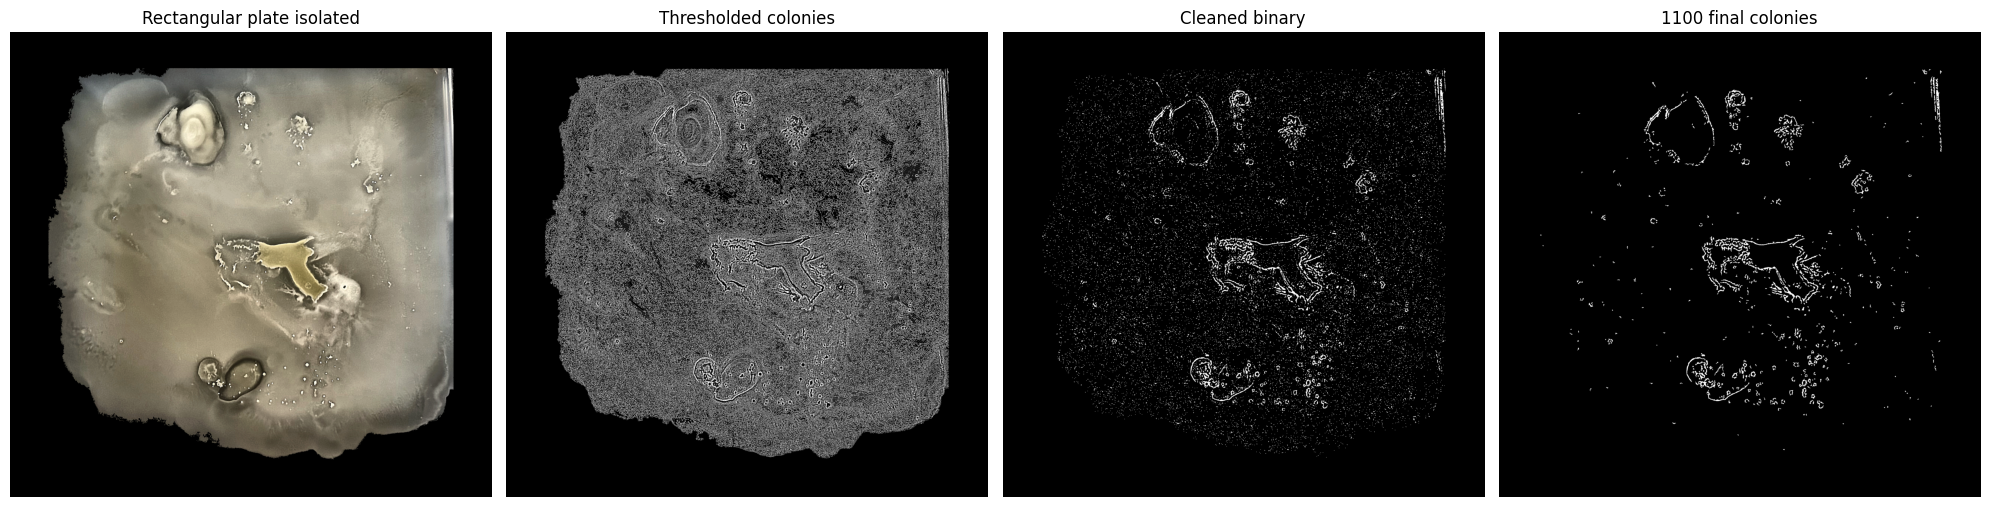

In [ ]:
#Section 6

# Goal: Identify each bacterial colony as its own blob within the dish boundary.
# Input: The enhanced dish image plus the dish interior outline.
# Output: A labeled map showing separate colony regions and a count of how many were found.


def segment_colonies_rect(processed_image, plate_mask):
    print("Segmenting colonies in rectangular plate")

    # apply rectangular plate mask first to the image
    masked_img = cv2.bitwise_and(processed_image, processed_image, mask=plate_mask)

    gray = cv2.cvtColor(masked_img, cv2.COLOR_RGB2GRAY)
    hsv = cv2.cvtColor(masked_img, cv2.COLOR_RGB2HSV)

    # adaptive threshold with larger block size for rectangular plates
    binary = cv2.adaptiveThreshold(gray, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C,
                                   cv2.THRESH_BINARY_INV, 15, 3)

    # apply plate mask to binary
    binary = cv2.bitwise_and(binary, plate_mask)

    # morphological operations
    kernel_small = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (3, 3))
    kernel_medium = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (5, 5))

    binary_clean = cv2.morphologyEx(binary, cv2.MORPH_OPEN, kernel_small)
    binary_clean = cv2.morphologyEx(binary_clean, cv2.MORPH_CLOSE, kernel_medium)

    # watershed for touching colonies
    distance = ndimage.distance_transform_edt(binary_clean)
    coords = peak_local_max(distance, min_distance=8, threshold_abs=0.3*distance.max())

    if len(coords) > 0:
        markers = np.zeros_like(binary_clean, dtype=np.int32)
        for i, coord in enumerate(coords):
            markers[coord[0], coord[1]] = i + 1
        labels = segmentation.watershed(-distance, markers, mask=binary_clean)
    else:
        num_labels, labels = cv2.connectedComponents(binary_clean)

    # filter by size - adjust for rectangular plates
    min_colony_size = 15
    max_colony_size = 10000
    colony_props = measure.regionprops(labels)

    valid_colonies = []
    valid_label_mask = np.zeros_like(labels)

    for new_id, prop in enumerate(colony_props, start=1):
        if min_colony_size <= prop.area <= max_colony_size:
            valid_colonies.append(prop)
            valid_label_mask[labels == prop.label] = new_id

    print(f"Found {len(valid_colonies)} colonies in rectangular plate")

    # visualization
    plt.figure(figsize=(20, 5))

    plt.subplot(1, 4, 1)
    plt.imshow(masked_img)
    plt.title('Rectangular plate isolated')
    plt.axis('off')

    plt.subplot(1, 4, 2)
    plt.imshow(binary, cmap='gray')
    plt.title('Thresholded colonies')
    plt.axis('off')

    plt.subplot(1, 4, 3)
    plt.imshow(binary_clean, cmap='gray')
    plt.title('Cleaned binary')
    plt.axis('off')

    plt.subplot(1, 4, 4)
    plt.imshow(valid_label_mask > 0, cmap='gray')
    plt.title(f'{len(valid_colonies)} final colonies')
    plt.axis('off')

    plt.tight_layout()
    plt.show()

    return valid_label_mask, valid_colonies


#usage: this is just running your function to get the output

colony_labels, colony_properties = segment_colonies_rect(processed_image, plate_mask)

### Colony segmentation complete – valid colonies have been detected and separated.
### Overlapping colonies have been split using watershed, and noisy regions have been filtered out.
### Next step: we will analyze the color of each colony and group them based on visual similarity.

## **Section 7: Colony Morphology Analysis**
### This section computes basic shape features for each colony and classifies their overall form and edge type.  
### Key Steps:  
### 1. Measure area, perimeter, and major/minor axis lengths  
### 2. Calculate circularity and aspect ratio to gauge roundness vs. elongation  
### 3. Determine convexity and margin complexity for edge smoothness vs. jaggedness  
### 4. Assign each colony a form category (circular, oval, filamentous, irregular) and margin type (entire, undulate, lobate, serrate)  
### 5. Summarize results in a table and plot the counts of each form  


Starting morphology analysis


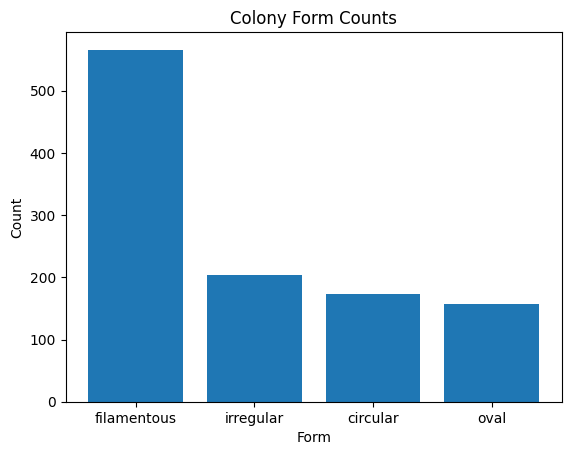

In [ ]:
#Section 7: Colony Morphology Analysis

# Goal: Measure each colony’s shape—how big, round, long, or jagged it is—and classify its edge style.
# Input: The map of colony regions.
# Output: A table listing size, roundness, elongation, solidity, edge smoothness, and form category for every colony.


def analyze_colony_morphology(colony_labels, colony_properties):
    # extract area, perimeter, axes lengths, solidity, extent, convexity, margin complexity, form, and margin
    import cv2
    data = []
    for idx, prop in enumerate(colony_properties):
        area = prop.area
        perimeter = prop.perimeter
        major_axis = prop.major_axis_length
        minor_axis = prop.minor_axis_length
        circularity = 4 * np.pi * area / (perimeter ** 2) if perimeter > 0 else 0
        aspect_ratio = major_axis / minor_axis if minor_axis > 0 else 1
        solidity = prop.solidity
        extent = prop.extent
        mask = (colony_labels == prop.label).astype('uint8')
        contours, _ = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
        if contours:
            cnt = max(contours, key=cv2.contourArea)
            hull = cv2.convexHull(cnt)
            hull_area = cv2.contourArea(hull)
            convexity = area / hull_area if hull_area > 0 else 1
            epsilon = 0.02 * cv2.arcLength(cnt, True)
            approx = cv2.approxPolyDP(cnt, epsilon, True)
            margin_complexity = len(approx) / area * 1000
            if convexity > 0.95 and margin_complexity < 0.1:
                margin = 'entire'
            elif convexity > 0.85:
                margin = 'undulate'
            elif margin_complexity > 0.3:
                margin = 'serrate'
            else:
                margin = 'lobate'
        else:
            convexity = 1
            margin_complexity = 0
            margin = 'unknown'
        if circularity > 0.85:
            form = 'circular'
        elif aspect_ratio > 2.0:
            form = 'filamentous'
        elif circularity < 0.6:
            form = 'irregular'
        else:
            form = 'oval'
        data.append({
            'colony_id': idx,
            'area': area,
            'perimeter': perimeter,
            'circularity': circularity,
            'aspect_ratio': aspect_ratio,
            'solidity': solidity,
            'extent': extent,
            'convexity': convexity,
            'margin_complexity': margin_complexity,
            'form': form,
            'margin': margin
        })
    return pd.DataFrame(data)

print('Starting morphology analysis')

#usage: this is just running your function to get the output

morph_df = analyze_colony_morphology(colony_labels, colony_properties)
#print(morph_df)

# plot morphology form counts
counts = morph_df['form'].value_counts()
plt.figure()
plt.bar(counts.index, counts.values)
plt.xlabel('Form')
plt.ylabel('Count')
plt.title('Colony Form Counts')
plt.show()

## **Section 8: Colony Color Clustering**

### This section extracts the main colors of each colony and groups colonies that look similar by color.  
### Key Steps:  
### 1. For each colony, find its dominant RGB color using K-means (chooses the most common color in the blob)  
### 2. Convert those RGB colors to Lab space (Lab separates lightness from color for better comparison)  
### 3. Scale the Lab values and use the elbow method (find the “knee” in the error curve) to pick the best number of color groups  
### 4. Cluster the Lab colors into groups with K-means  
### 5. Assign each colony to a color cluster and compute one representative color per group  
### 6. Draw contours on the image in distinct colors to show each group  
### 7. Display a legend with group counts and color patches for a quick visual summary  


Analyzing colony colors with kmeans clustering
Extracted colors from 1100 colonies
kmeans found 6 color groups
Processed 1100 colonies into 6 color groups


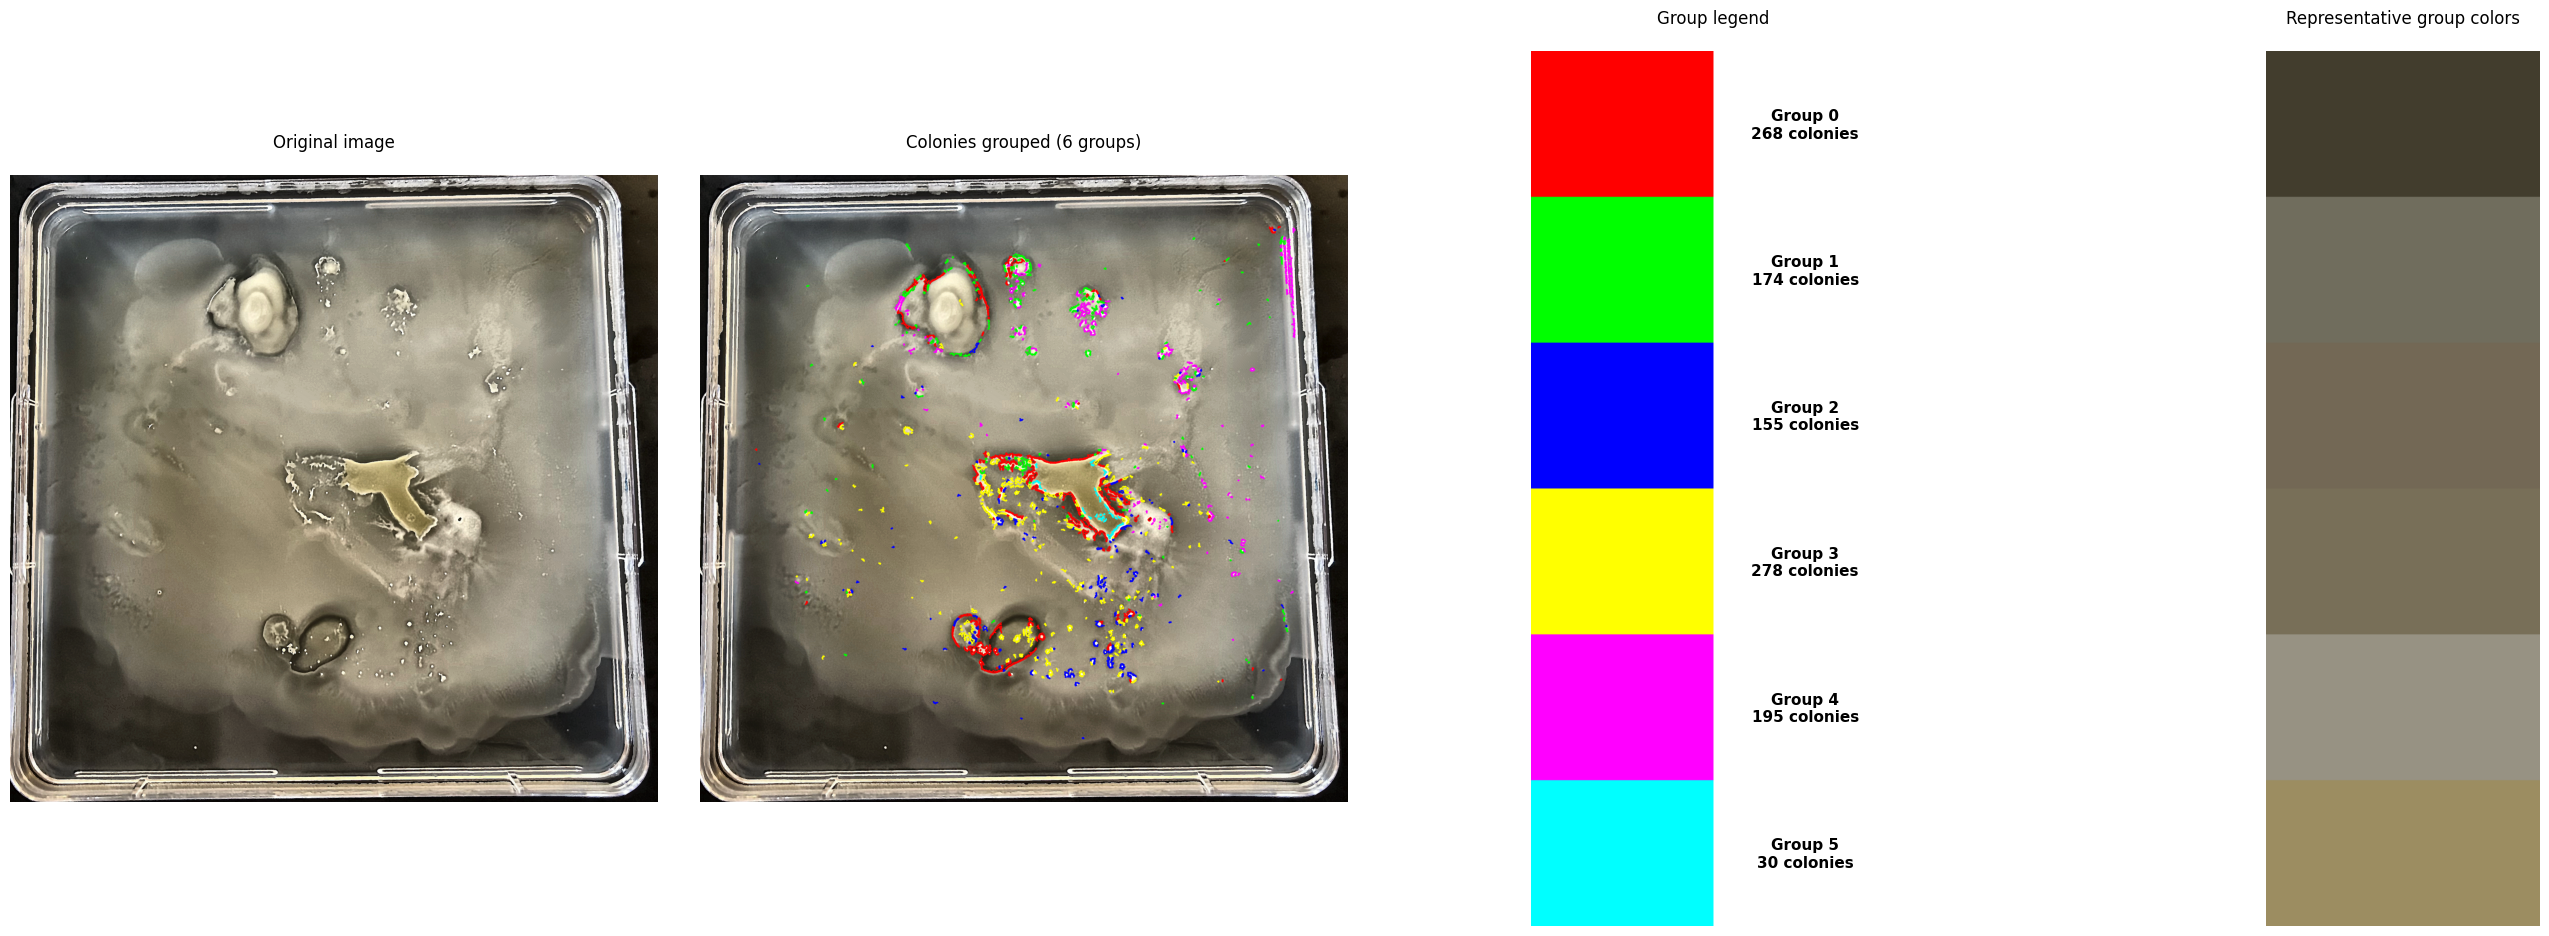

In [ ]:
#Section 8: Colony Color Clustering

# Goal: Pick the dominant color of each colony and group colonies that share similar hues.
# Input: The original dish photo and the boundary of each colony.
# Output: A list of representative colors and group labels showing which colonies look alike.



import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from skimage import color
import cv2
from collections import Counter

def extract_dominant_colors(colony_pixels, n_colors=3):
    """get dominant colors instead of mean"""
    if len(colony_pixels) < 10:
        return np.mean(colony_pixels, axis=0)

    pixels_reshaped = colony_pixels.reshape(-1, 3)
    kmeans = KMeans(n_clusters=min(n_colors, len(pixels_reshaped)),
                   random_state=42, n_init=5)
    kmeans.fit(pixels_reshaped)

    labels = kmeans.labels_
    label_counts = Counter(labels)
    dominant_label = label_counts.most_common(1)[0][0]

    return kmeans.cluster_centers_[dominant_label]

def rgb_to_lab_batch(rgb_colors):
    #convert rgb to lab color space
    rgb_normalized = rgb_colors / 255.0
    lab_colors = []

    for rgb in rgb_normalized:
        rgb_img = rgb.reshape(1, 1, 3)
        lab_img = color.rgb2lab(rgb_img)
        lab_colors.append(lab_img[0, 0])

    return np.array(lab_colors)

def analyze_colony_colors_kmeans(processed_image, colony_labels, colony_properties):
    print("Analyzing colony colors with kmeans clustering")

    if len(colony_properties) == 0:
        return [], []

    colony_data = []
    rgb_colors = []

    # extract dominant colors
    for i, prop in enumerate(colony_properties):
        mask = (colony_labels == prop.label)
        colony_pixels = processed_image[mask]

        if len(colony_pixels) > 0:
            dominant_rgb = extract_dominant_colors(colony_pixels)

            colony_info = {
                'colony_id': i,
                'label': prop.label,
                'area': prop.area,
                'centroid': prop.centroid,
                'dominant_color': dominant_rgb
            }

            colony_data.append(colony_info)
            rgb_colors.append(dominant_rgb)

    if len(rgb_colors) == 0:
        print("no valid colonies found")
        return [], []

    rgb_colors = np.array(rgb_colors)
    lab_colors = rgb_to_lab_batch(rgb_colors)

    print(f"Extracted colors from {len(colony_data)} colonies")

    # find optimal number of clusters using elbow method
    if len(lab_colors) > 1:
        scaler = StandardScaler()
        lab_scaled = scaler.fit_transform(lab_colors)

        best_k = 3
        if len(lab_colors) > 4:
            inertias = []
            k_range = range(2, min(8, len(lab_colors)))

            for k in k_range:
                kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
                kmeans.fit(lab_scaled)
                inertias.append(kmeans.inertia_)

            # find elbow point
            if len(inertias) > 2:
                diffs = np.diff(inertias)
                best_k = k_range[np.argmax(diffs)] if len(diffs) > 0 else 3

        # final clustering
        kmeans = KMeans(n_clusters=best_k, random_state=42, n_init=10)
        clusters = kmeans.fit_predict(lab_scaled)

        print(f"kmeans found {best_k} color groups")
    else:
        clusters = np.zeros(len(colony_data))
        best_k = 1

    # assign clusters to colony data
    for i, cluster in enumerate(clusters):
        colony_data[i]['color_cluster'] = int(cluster)

    # get cluster center colors (one representative color per group)
    cluster_representative_colors = []
    for cluster_id in range(best_k):
        cluster_mask = clusters == cluster_id
        if np.any(cluster_mask):
            # use the actual kmeans cluster center in lab space, convert back to rgb
            cluster_lab = lab_colors[cluster_mask]
            center_lab = np.mean(cluster_lab, axis=0)

            # convert back to rgb using skimage.color
            center_lab_img = center_lab.reshape(1, 1, 3)
            from skimage import color as skcolor
            center_rgb_img = skcolor.lab2rgb(center_lab_img)
            center_rgb = (center_rgb_img[0, 0] * 255).astype(int)
            cluster_representative_colors.append(center_rgb)
        else:
            cluster_representative_colors.append([128, 128, 128])

    cluster_representative_colors = np.array(cluster_representative_colors)

    # visualization
    plt.figure(figsize=(28, 10))

    # plot 1: original image
    plt.subplot(1, 4, 1)
    plt.imshow(processed_image)
    plt.title('Original image', fontsize=12, pad=20)
    plt.axis('off')

    # plot 2: colonies with clustering using distinct colors
    plt.subplot(1, 4, 2)
    img_overlay = processed_image.copy()

    # use distinct solid colors for each group
    distinct_colors = [
        [255, 0, 0],      # red
        [0, 255, 0],      # green
        [0, 0, 255],      # blue
        [255, 255, 0],    # yellow
        [255, 0, 255],    # magenta
        [0, 255, 255],    # cyan
        [255, 128, 0],    # orange
        [128, 0, 255],    # purple
    ]

    for i, data in enumerate(colony_data):
        cluster = data['color_cluster']
        color = distinct_colors[cluster % len(distinct_colors)]

        mask = (colony_labels == data['label']).astype(np.uint8)
        contours, _ = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
        cv2.drawContours(img_overlay, contours, -1, color, 4)

    plt.imshow(img_overlay)
    plt.title(f'Colonies grouped ({best_k} groups)', fontsize=12, pad=20)
    plt.axis('off')

    # plot 3: color legend
    plt.subplot(1, 4, 3)
    legend_img = np.ones((best_k * 80, 200, 3), dtype=np.uint8) * 255

    for cluster_id in range(best_k):
        start_y = cluster_id * 80
        end_y = (cluster_id + 1) * 80
        color = distinct_colors[cluster_id % len(distinct_colors)]
        legend_img[start_y:end_y, :100] = color

        # add text on white background
        n_colonies = np.sum(clusters == cluster_id)
        plt.text(150, start_y + 40, f'Group {cluster_id}\n{n_colonies} colonies',
                ha='center', va='center', fontsize=11, weight='bold')

    plt.imshow(legend_img)
    plt.title('Group legend', fontsize=12, pad=20)
    plt.axis('off')

    # plot 4: representative colors (one solid color per group) here, each colony is assigned to a particular colour group. It will be part of the color group which is closest match to its own color.
    #number of colour groups we have identified through K-means clustering.
    plt.subplot(1, 4, 4)

    group_height = 80
    total_height = best_k * group_height
    patch_width = 150

    color_patches = np.ones((total_height, patch_width, 3), dtype=np.uint8) * 255

    for cluster_id in range(best_k):
        start_y = cluster_id * group_height
        end_y = (cluster_id + 1) * group_height

        representative_color = cluster_representative_colors[cluster_id]
        color_patches[start_y:end_y, :] = representative_color.astype(np.uint8)

    plt.imshow(color_patches)
    plt.title('Representative group colors', fontsize=12, pad=20)
    plt.axis('off')

    plt.tight_layout(pad=3.0)

    print(f"Processed {len(colony_data)} colonies into {best_k} color groups")

    return colony_data, clusters


#usage: this is just running your function to get the output

colony_data, clusters = analyze_colony_colors_kmeans(processed_image, colony_labels, colony_properties)

## **Section 9: Colony Density and Opacity Analysis**

### Purpose:
### This section evaluates the internal characteristics of each bacterial colony based on how light or dark it appears, how uniform its structure is, and how the brightness changes from the center to the edge.
### These measurements help classify colonies as dense, sparse, or somewhere in between.

### Key Concepts and Steps:
### 1. Convert the plate image to grayscale and HSV (for brightness and color info)
### 2. Calculate the average background brightness to use as a reference
### 3. For each colony:
###   i. Measure brightness (mean intensity) and variation within the colony
###   ii. Compute the opacity score (how different it is from background)
###   iii. Check brightness difference from center to edge (density gradient)
###   iv. Calculate texture (using local intensity variance)
###   v. Estimate how saturated the colony’s color is (from HSV, HSV stands for Hue, Saturation, and Value. It's a way of representing colors that's often more intuitive than RGB (Red, Green, Blue), especially for tasks like image analysis, color detection, or filtering.)
### 4. Use these features to classify each colony into five categories:
###   'very_dense', 'dense', 'medium', 'sparse', 'very_sparse'
### 5. Optionally group colonies into clusters based on their density features
### 6. Visualize:
###   a. A scatter plot of opacity vs. density gradient
###   b.  A pie chart showing how many colonies fall into each density class

Analyzing colony density


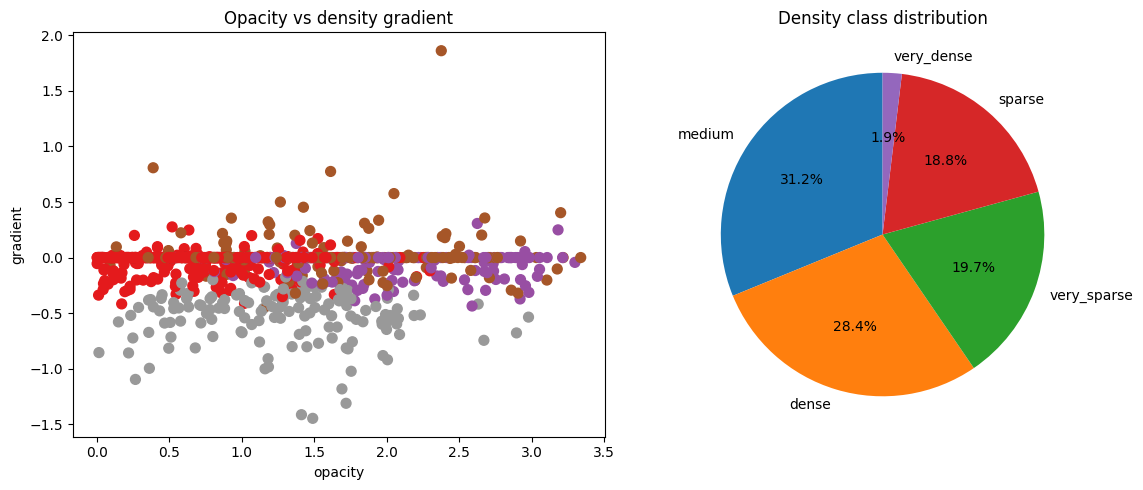


Done with density analysis
Top 3 densest colonies:
      colony_id  opacity_score density_class
1072       1072       3.337967         dense
347         347       3.297958         dense
694         694       3.216471         dense


In [ ]:
#Section 9: Colony Density and Opacity Analysis

# Goal: Quantify how dense or see-through each colony appears by looking at brightness and texture.
# Input: The preprocessed dish photo, colony outlines, and dish interior boundary.
# Output: A table of brightness, contrast, texture metrics, and a density class (e.g., sparse, medium, dense) for each colony.


def analyze_individual_colony_density(processed_image, colony_labels, colony_properties, plate_mask):
    import numpy as np
    import matplotlib.pyplot as plt
    import cv2
    from sklearn.cluster import KMeans
    from scipy import ndimage
    import pandas as pd
    from skimage import filters, measure

    print("Analyzing colony density")

    gray_image = cv2.cvtColor(processed_image, cv2.COLOR_RGB2GRAY)
    hsv_image = cv2.cvtColor(processed_image, cv2.COLOR_RGB2HSV)

    background_mask = plate_mask.copy()
    background_mask[colony_labels > 0] = 0
    background_pixels = gray_image[background_mask > 0]
    background_mean = np.mean(background_pixels) if len(background_pixels) > 0 else 128
    background_std = np.std(background_pixels) if len(background_pixels) > 0 else 30

    colony_density_data = []

    for i, prop in enumerate(colony_properties):
        #print(f"processing colony {i+1}/{len(colony_properties)}")

        minr, minc, maxr, maxc = prop.bbox
        colony_region_gray = gray_image[minr:maxr, minc:maxc]
        colony_region_hsv = hsv_image[minr:maxr, minc:maxc]
        colony_mask_region = (colony_labels[minr:maxr, minc:maxc] == prop.label)

        if not np.any(colony_mask_region):
            continue

        colony_pixels_gray = colony_region_gray[colony_mask_region]
        colony_pixels_hsv = colony_region_hsv[colony_mask_region]

        mean_intensity = np.mean(colony_pixels_gray)
        std_intensity = np.std(colony_pixels_gray)
        opacity_score = abs(mean_intensity - background_mean) / background_std
        density_uniformity = 1.0 / (std_intensity + 1)

        distance_transform = ndimage.distance_transform_edt(colony_mask_region)
        max_distance = np.max(distance_transform)

        if max_distance > 3:
            center_mask = distance_transform >= max_distance * 0.5
            edge_mask = distance_transform <= max_distance * 0.3
            center_pixels = colony_region_gray[colony_mask_region & center_mask]
            edge_pixels = colony_region_gray[colony_mask_region & edge_mask]
            center_density = np.mean(center_pixels) if len(center_pixels) > 0 else mean_intensity
            edge_density = np.mean(edge_pixels) if len(edge_pixels) > 0 else mean_intensity
            density_gradient = (center_density - edge_density) / background_std
        else:
            center_density = edge_density = mean_intensity
            density_gradient = 0

        kernel_size = max(3, min(7, int(np.sqrt(prop.area) // 3)))
        if kernel_size % 2 == 0:
            kernel_size += 1

        local_var = ndimage.generic_filter(colony_region_gray.astype(float), np.var, size=kernel_size)
        texture_score = np.mean(local_var[colony_mask_region])
        mean_saturation = np.mean(colony_pixels_hsv[:, 1])

        if opacity_score > 2.0 and density_uniformity > 0.1:
            density_class = "very_dense"
        elif opacity_score > 1.5:
            density_class = "dense"
        elif opacity_score > 0.8:
            density_class = "medium"
        elif opacity_score > 0.4:
            density_class = "sparse"
        else:
            density_class = "very_sparse"

        colony_info = {
            'colony_id': i,
            'area': prop.area,
            'mean_intensity': mean_intensity,
            'opacity_score': opacity_score,
            'density_uniformity': density_uniformity,
            'density_gradient': density_gradient,
            'texture_score': texture_score,
            'mean_saturation': mean_saturation,
            'density_class': density_class
        }

        colony_density_data.append(colony_info)

    df = pd.DataFrame(colony_density_data)

    if len(df) > 3:
        from sklearn.preprocessing import StandardScaler
        features = df[['opacity_score', 'density_uniformity', 'density_gradient', 'texture_score', 'mean_saturation']]
        scaled = StandardScaler().fit_transform(features)
        kmeans = KMeans(n_clusters=min(4, max(2, len(df)//5)), random_state=42, n_init=10)
        df['density_cluster'] = kmeans.fit_predict(scaled)
    else:
        # assign a default cluster if not enough data for clustering
        df['density_cluster'] = 0

    # corrected subplot creation and plotting
    fig, axes = plt.subplots(1, 2, figsize=(12, 5))

    # scatter plot
    if not df.empty: # Check if DataFrame is not empty before plotting
        axes[0].scatter(df['opacity_score'], df['density_gradient'], c=df['density_cluster'], cmap='Set1', s=50)
        axes[0].set_title('Opacity vs density gradient')
        axes[0].set_xlabel('opacity')
        axes[0].set_ylabel('gradient')
    else:
        axes[0].text(0.5, 0.5, 'No data to plot scatter', horizontalalignment='center', verticalalignment='center')
        axes[0].set_title('Opacity vs density gradient')


    #pie chart
    density_counts = df['density_class'].value_counts()
    if not density_counts.empty: # Check if density_counts is not empty before plotting
        axes[1].pie(density_counts.values, labels=density_counts.index, autopct='%1.1f%%', startangle=90)
        axes[1].set_title('Density class distribution')
    else:
        axes[1].text(0.5, 0.5, 'No data to plot pie chart', horizontalalignment='center', verticalalignment='center')
        axes[1].set_title('Density class distribution')


    plt.tight_layout()
    plt.show()

    print("\nDone with density analysis")
    if not df.empty: # check if DataFrame is not empty before printing top colonies
        print("Top 3 densest colonies:")
        print(df.nlargest(3, 'opacity_score')[['colony_id', 'opacity_score', 'density_class']])
    else:
        print("No colonies found for density analysis.")


    return df

#usage: this is just running your function to get the output

result_df = analyze_individual_colony_density(processed_image, colony_labels, colony_properties, plate_mask)

## **Section 10: Combined Analysis and Scoring**
### This section merges morphology, color, and density data and computes a final interest score for each colony  
### Key Steps:  
### 1. Merge morphology, color, and density DataFrames into one table  
### 2. Fill missing values with zeros  
### 3. Calculate morphology_score from percentile-based shape metrics  
### 4. Compute form_score based on how rare each colony form is  
### 5. Determine size_score from area rankings  
### 6. Compute density_score with enhanced weighting and density bonuses  
### 7. Map margin_score from colony edge types  
### 8. Combine all weighted scores into a base score (bio_base)  
### 9. Add novelty_combo bonus for very rare form–color pairs  
### 10. Subtract penalties for overly common features  
### 11. Clamp the final bio_interest score between 0 and 1  
### 12. Select a diverse top set of colonies enforcing quotas per color cluster  


In [ ]:
#Section 10: Combined Analysis and Scoring

# Goal: Bring together shape, color, and density data into a single “interest” score for each colony.
# Input: The tables of colony shapes, color groups, and density measures.
# Output: A merged dataset with every colony assigned a final score and a shortlist of top candidates.



def combine_all_analyses_and_score(morph_df, colony_data, density_df, processed_image, colony_labels, colony_properties):
    #combines morphology, color, density data and calculates comprehensive scores
    print("combining all colony analysis data")

    # convert color data to dataframe if needed
    if isinstance(colony_data, list):
        color_df = pd.DataFrame([{
            'colony_id': data['colony_id'],
            'area': data['area'],
            'color_cluster': data.get('color_cluster', 0),
            'color_class': f"color_group_{data.get('color_cluster', 0)}"
        } for data in colony_data])
    else:
        color_df = colony_data

    # merge all dataframes
    combined_df = morph_df.copy()
    if not color_df.empty:
        combined_df = combined_df.merge(color_df, on='colony_id', how='outer')
    if not density_df.empty:
        combined_df = combined_df.merge(density_df, on='colony_id', how='outer')

    # fill missing values
    combined_df = combined_df.fillna(0)

    print(f"combined data for {len(combined_df)} colonies")
    return combined_df

# calculate optimized scores with maximal diversity constraints and targeted novelty rewards
def calculate_optimized_scores(combined_df):
    #compute base scores penalizing common features and rewarding rare combos
    scores = pd.DataFrame({'colony_id': combined_df['colony_id']})

    # morphological complexity
    morph_vals = []
    for f in ['circularity','aspect_ratio','solidity','convexity','margin_complexity']:
        if f in combined_df:
            v = combined_df[f].fillna(combined_df[f].median())
            pct = v.rank(pct=True)
            morph_vals.append(np.minimum(pct,1-pct)*2)
    scores['morphology_score'] = np.mean(morph_vals, axis=0) if morph_vals else 0.5

    # form rarity score
    if 'form' in combined_df:
        freq_f = combined_df['form'].value_counts(normalize=True)
        scores['form_score'] = combined_df['form'].map(lambda x: (1-freq_f[x])**0.8)
    else:
        scores['form_score'] = 0.5

    # size preference
    if 'area' in combined_df:
        pct = np.log1p(combined_df['area']).rank(pct=True)
        scores['size_score'] = np.where((pct>=0.2)&(pct<=0.8),1,0.5)
    else:
        scores['size_score'] = 0.5

    # ENHANCED density complexity - prioritizes dense colonies much more
    if 'opacity_score' in combined_df:
        norm = combined_df['opacity_score']/combined_df['opacity_score'].max()
        # Apply exponential scaling to heavily favor dense colonies
        scores['density_score'] = np.clip(norm**0.5 * 1.5, 0, 1)

        # Additional density bonus for top quartile
        density_threshold = np.percentile(combined_df['opacity_score'], 75)
        density_bonus = np.where(combined_df['opacity_score'] >= density_threshold, 0.3, 0)
        scores['density_bonus'] = density_bonus
    else:
        scores['density_score'] = 0.5
        scores['density_bonus'] = 0

    # Alternative: if you have density_class, prioritize 'dense' class
    if 'density_class' in combined_df:
        density_class_bonus = combined_df['density_class'].map({
            'dense': 0.4,
            'medium': 0.1,
            'sparse': 0.0
        }).fillna(0)
        scores['density_class_bonus'] = density_class_bonus
    else:
        scores['density_class_bonus'] = 0

    # margin preference
    if 'margin' in combined_df:
        interest = {'smooth':0.2,'rough':0.6,'irregular':1.0,'lobate':0.8}
        scores['margin_score'] = combined_df['margin'].map(lambda x: interest.get(x,0.5))
    else:
        scores['margin_score'] = 0.5

    # base interest removing color bias - INCREASED density weight
    weights = {
        'morphology_score': 0.35,
        'form_score': 0.1,
        'size_score': 0.1,
        'density_score': 0.35,
        'margin_score': 0.1
    }
    scores['bio_base'] = sum(scores[f]*w for f,w in weights.items())

    # combo novelty reward: extremely rare combos (<3%) boosted
    combo = None
    if 'color_cluster' in combined_df and 'form' in combined_df:
        combo = combined_df['color_cluster'].astype(str)+'_'+combined_df['form'].astype(str)
        freq_combo = combo.value_counts(normalize=True)
        scores['novelty_combo'] = combo.map(lambda x: (1-freq_combo[x])*0.3 if freq_combo[x]<0.03 else 0)
    else:
        scores['novelty_combo'] = 0

    # exponential penalties on common features
    pen_vals = np.zeros(len(combined_df))
    if 'color_cluster' in combined_df:
        freq_c = combined_df['color_cluster'].value_counts(normalize=True)
        pen_vals += combined_df['color_cluster'].map(lambda x: freq_c[x]**2)
    if 'form' in combined_df:
        pen_vals += combined_df['form'].map(lambda x: freq_f[x]**2)
    if combo is not None:
        pen_vals += combo.map(lambda x: freq_combo[x]**2)
    scores['penalty'] = (pen_vals/3) * 0.7

    # final raw interest score - ADD density bonuses
    total_density_bonus = scores['density_bonus'] + scores['density_class_bonus']
    scores['bio_interest'] = np.clip(
        scores['bio_base'] + scores['novelty_combo'] - scores['penalty'] + total_density_bonus,
        0, 1
    )

    # attach metadata
    for c in ['color_cluster','form','margin','area','density_class']:
        if c in combined_df:
            scores[c] = combined_df[c]
    return scores

# greedy selection with quotas to ensure minimal cluster representation
def select_diverse_top(scores_df, n=20, penalty_factor=0.5):
    #pick top scoring colonies while enforcing minimum per-cluster quota
    selected = []
    pool = scores_df.copy().set_index('colony_id')
    # determine quotas per unique color cluster
    clusters = pool['color_cluster'].unique() if 'color_cluster' in pool else []
    k = len(clusters)
    min_quota = n // k if k>0 else 0
    quota = {c:0 for c in clusters}

    for _ in range(n):
        if pool.empty:
            break
        # enforce quota: select from clusters under quota first
        under = [c for c,count in quota.items() if count < min_quota]
        if under:
            cand = pool[pool['color_cluster'].isin(under)]
        else:
            cand = pool
        # pick best candidate
        best = cand['bio_interest'].idxmax()
        selected.append(best)
        # update quota
        if 'color_cluster' in pool:
            c = pool.loc[best,'color_cluster']
            quota[c] = quota.get(c,0) + 1
        # penalize same cluster/form in pool
        attrs = ['color_cluster','form']
        row = pool.loc[best]
        for attr in attrs:
            if attr in row:
                mask = pool[attr]==row[attr]
                pool.loc[mask,'bio_interest'] *= (1-penalty_factor)
        # remove picked
        pool = pool.drop(best)
    return scores_df.set_index('colony_id').loc[selected].reset_index()

#usage: this is just running your function to get the output
if __name__ == "__main__":
    print("Running maximal-diversity optimized scoring with enhanced density priority")
    combined_data = combine_all_analyses_and_score(
    morph_df, colony_data, result_df, processed_image, colony_labels, colony_properties
)
    raw_scores = calculate_optimized_scores(combined_data)
    top_diverse = select_diverse_top(raw_scores, n=20)
    print("Diverse top 20 colonies:")
    print(top_diverse.round(3).to_string(index=False))

Running maximal-diversity optimized scoring with enhanced density priority
combining all colony analysis data
combined data for 1100 colonies
Diverse top 20 colonies:
 colony_id  morphology_score  form_score  size_score  density_score  density_bonus  density_class_bonus  margin_score  bio_base  novelty_combo  penalty  bio_interest  color_cluster        form   margin  area density_class
         2             0.579       0.561         0.5          1.000            0.3                  0.4           0.5     0.709          0.000    0.081           1.0              0 filamentous  serrate 347.0         dense
        13             0.696       0.849         0.5          1.000            0.0                  0.4           0.5     0.778          0.000    0.024           1.0              3   irregular undulate 140.0         dense
       117             0.698       0.884         1.0          0.840            0.0                  0.1           0.5     0.777          0.293    0.012           1.0  

## **Section 11: Zoomed Views of Top Colonies**

> Add blockquote


### This section highlights the top-scoring colonies on the full plate and shows close-up views of each  
### Key Steps:  
### 1. Mark the top 5 colonies on the full image with colored outlines and rank labels  
### 2. Display the original and marked images side by side for context  
### 3. For each top colony, extract a zoomed region around its center  



Showing top 5 colonies with zoom views


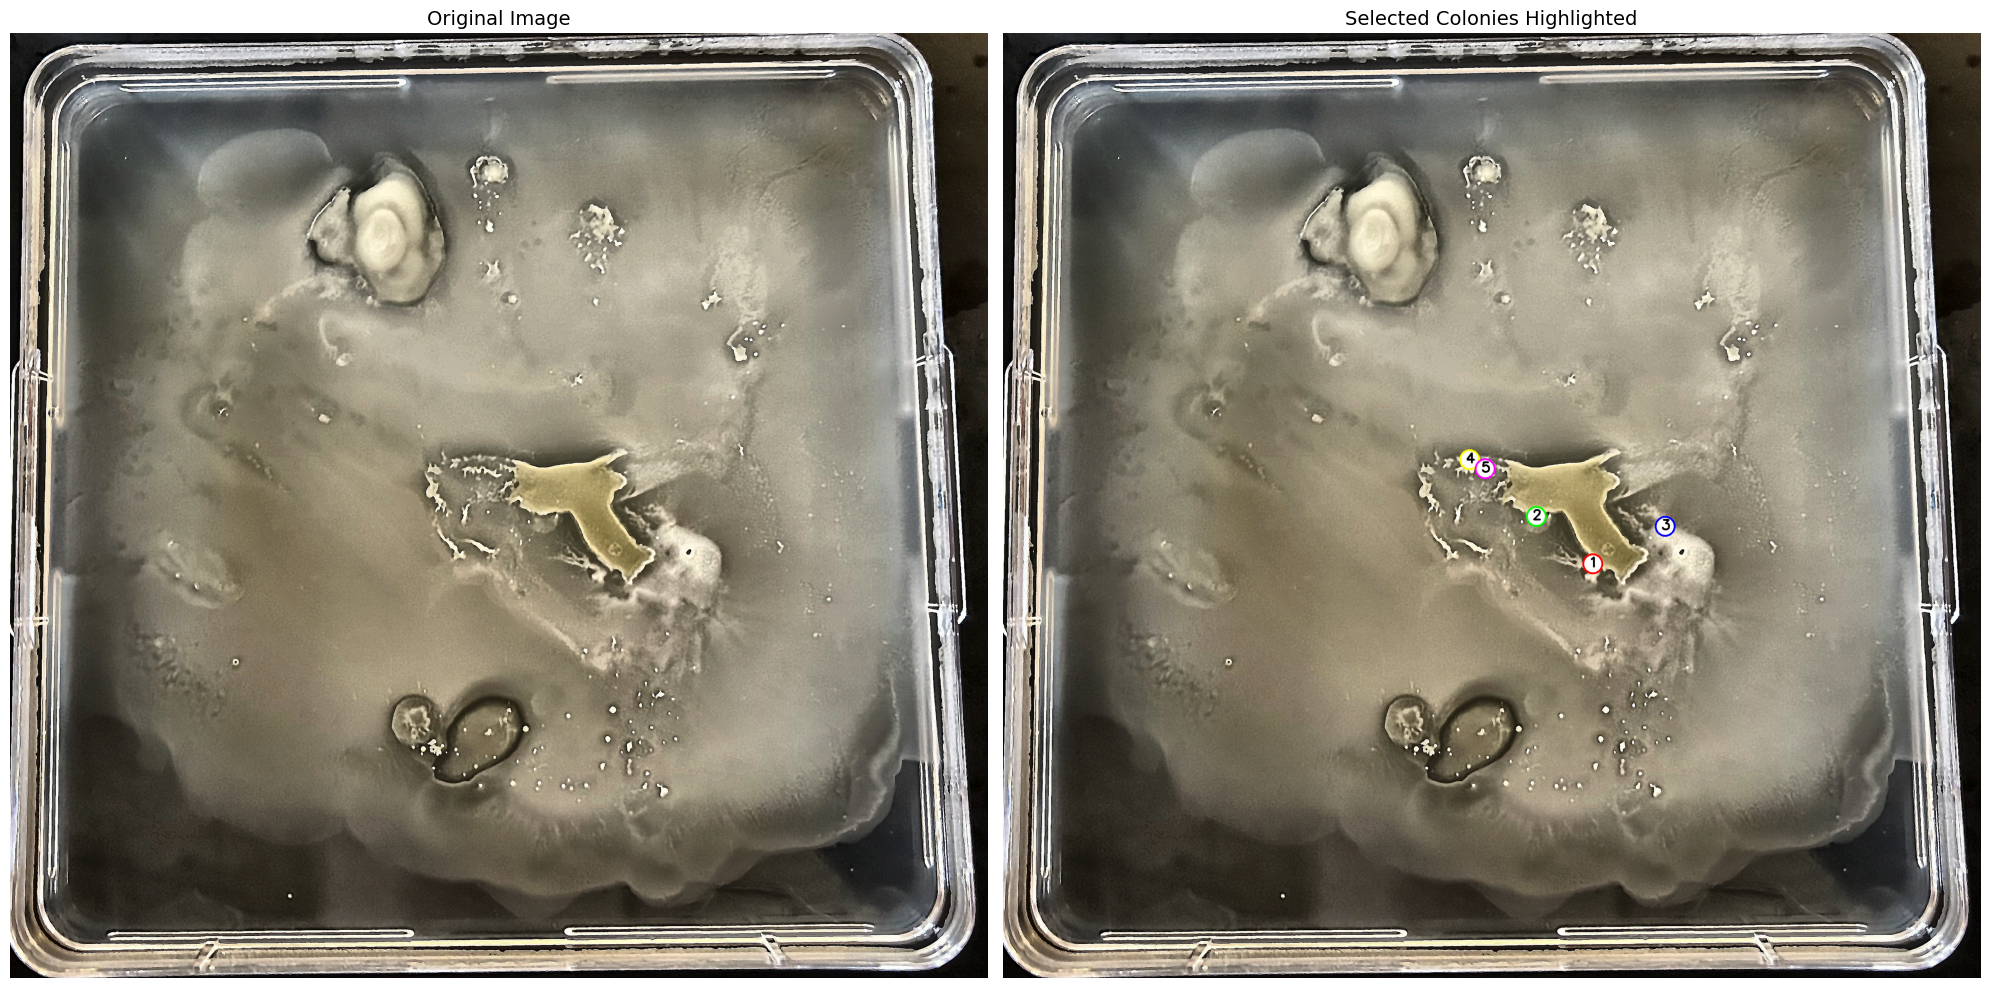

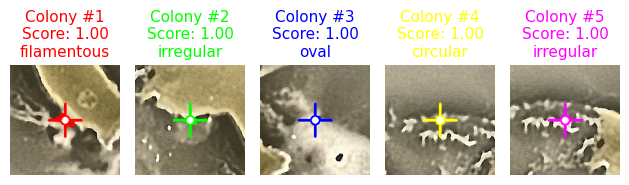

Showing full plate overview + 5 zoomed colony views


In [ ]:
#Section 11: Zoomed Views of Top Colonies

# Goal: Draw colored outlines around the highest-scoring colonies on the full dish and zoom in on each.
# Input: The original dish photo, colony region map, and ranked list of top colonies.
# Output: An annotated full-plate image plus close-up panels showing the top colonies in detail.


def show_top_5_colonies_zoomed(processed_image, colony_labels, colony_properties, top_diverse_df, n_top=5):

    #full image with marked colonies, then zoomed views of each top colony

    print(f"Showing top {n_top} colonies with zoom views")

    #top n colonies , you can notice n_top is mentioned in the definition of the function, you can change it to get specific number of colonies that you want
    top_colonies = top_diverse_df.head(n_top)

    #create marked image
    marked_image = processed_image.copy()
    colors = [(255, 0, 0), (0, 255, 0), (0, 0, 255), (255, 255, 0), (255, 0, 255)]

    #mark colonies on full image
    for idx, row in top_colonies.iterrows():
        colony_id = row['colony_id']
        rank = idx + 1
        color = colors[idx % len(colors)]

        prop = colony_properties[colony_id]
        colony_mask = (colony_labels == prop.label).astype(np.uint8)
        contours, _ = cv2.findContours(colony_mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

        if contours:
            # outline for the colonies
            cv2.drawContours(marked_image, contours, -1, color, thickness=6)

            # number of the colony to be mentioned in the marked image
            y_center, x_center = prop.centroid
            center_point = (int(x_center), int(y_center))
            cv2.circle(marked_image, center_point, 25, (255, 255, 255), -1)
            cv2.circle(marked_image, center_point, 25, color, 3)
            cv2.putText(marked_image, str(rank),
                       (int(x_center-10), int(y_center+8)),
                       cv2.FONT_HERSHEY_SIMPLEX, 1.2, (0, 0, 0), 3)

    #creating display of the image
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 10))

    # Left: original image
    ax1.imshow(processed_image)
    ax1.set_title('Original Image', fontsize=14)
    ax1.axis('off')

    # Right: selected colonies highlighted
    ax2.imshow(marked_image)
    ax2.set_title('Selected Colonies Highlighted', fontsize=14)
    ax2.axis('off')

    # spacing between the subplots
    plt.tight_layout()
    plt.show()

    # Individual zoomed views
    zoom_size = 100  # pixels around colony, you can change this if you wanna see even more focused image

    for idx, row in top_colonies.iterrows():
        colony_id = row['colony_id']
        rank = idx + 1
        color = colors[idx % len(colors)]

        prop = colony_properties[colony_id]
        y_center, x_center = prop.centroid

        # calculate zoom boundaries
        y_min = max(0, int(y_center - zoom_size))
        y_max = min(processed_image.shape[0], int(y_center + zoom_size))
        x_min = max(0, int(x_center - zoom_size))
        x_max = min(processed_image.shape[1], int(x_center + zoom_size))

        # extract zoomed region
        zoomed_region = processed_image[y_min:y_max, x_min:x_max].copy()
        zoomed_labels = colony_labels[y_min:y_max, x_min:x_max]

        # mark the specific colony in zoom
        colony_mask_zoom = (zoomed_labels == prop.label).astype(np.uint8)
        contours_zoom, _ = cv2.findContours(colony_mask_zoom, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

        if contours_zoom:
            #thick outline on zoomed view
            cv2.drawContours(zoomed_region, contours_zoom, -1, color, thickness=4)

            #crosshairs at center
            center_y_zoom = int(y_center - y_min)
            center_x_zoom = int(x_center - x_min)

            # Draw crosshairs
            cv2.line(zoomed_region, (center_x_zoom-30, center_y_zoom),
                    (center_x_zoom+30, center_y_zoom), color, 3)
            cv2.line(zoomed_region, (center_x_zoom, center_y_zoom-30),
                    (center_x_zoom, center_y_zoom+30), color, 3)


            cv2.circle(zoomed_region, (center_x_zoom, center_y_zoom), 8, (255, 255, 255), -1)
            cv2.circle(zoomed_region, (center_x_zoom, center_y_zoom), 8, color, 2)

        #display zoomed view, which could show the exact location of the colony
        ax_zoom = plt.subplot(2, 5, 5 + rank)
        ax_zoom.imshow(zoomed_region)

        #title with key info
        score = row['bio_interest']
        form = row.get('form', 'unknown')
        ax_zoom.set_title(f'Colony #{rank}\nScore: {score:.2f}\n{form}',
                         fontsize=11, color=np.array(color)/255)
        ax_zoom.axis('off')

    plt.tight_layout()
    plt.show()

    print(f"Showing full plate overview + {n_top} zoomed colony views")
    return marked_image

# usage : this is just running your function to get the output
marked_image = show_top_5_colonies_zoomed(processed_image, colony_labels, colony_properties, top_diverse)

## **Section 12: Zoomed Colony Views on Binary Mask**  

### The colonies are not clearly visible on original image, so we will display them on binary mask.
### 1. Create a binary mask where colonies are white (255) and background is black (0)  
### 2. Outline top 5 colonies on the binary mask with colored contours and rank labels  
### 3. Display the original binary mask and the highlighted version side by side  


showing top 5 colonies on binary mask with zoom views


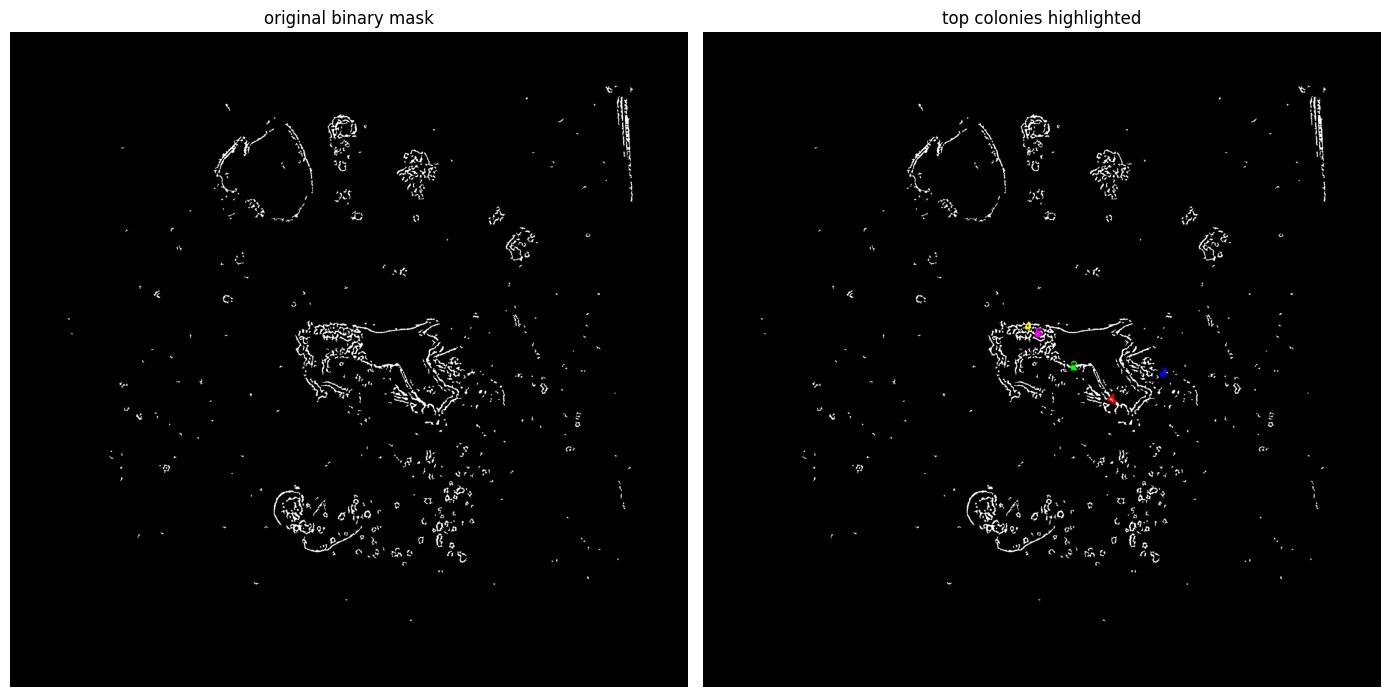

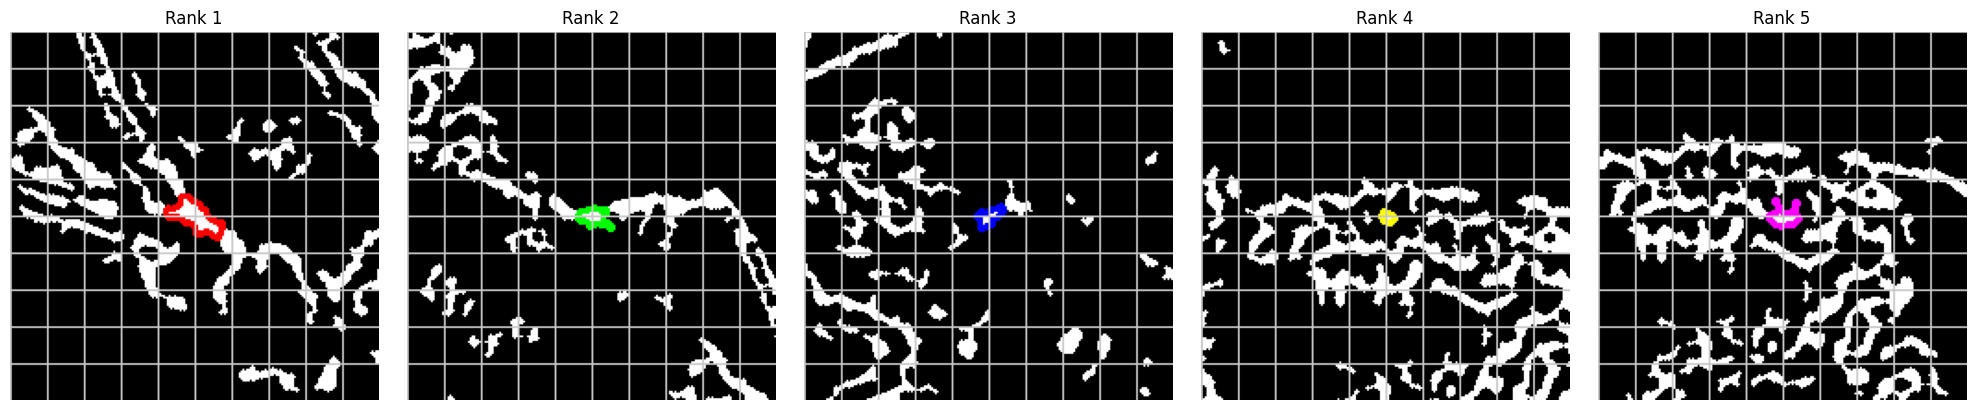

In [ ]:
#Section 12: Zoomed Colony Views on Binary Mask

# Goal: Provide an alternate view by outlining top colonies on a simple black-and-white mask with a measurement grid overlay.
# Input: A two-tone image where colonies are white and everything else is black, plus the ranked list.
# Output: Side-by-side views of the mask with colored outlines and zoomed-in grid-marked crops for precise sizing.


#creating black and white image wih colonies highlighted as white on black background.
if 'colony_labels' in locals() and colony_labels is not None and colony_labels.size > 0:
    # Create a binary image where colony regions are white (255) and background is black (0)
    binary_image_colony = (colony_labels > 0).astype(np.uint8) * 255


# this shows top n colonies outlined on the binary colony mask and then zooms into each with measurement grids
def show_top_5_colonies_zoomed(binary_image_colony, colony_labels, colony_properties, top_diverse, n_top=5):
    print(f"showing top {n_top} colonies on binary mask with zoom views")
    # get the top colonies
    top_colonies = top_diverse.head(n_top)

    # prepare marked image by converting to color
    marked_image = cv2.cvtColor(binary_image_colony, cv2.COLOR_GRAY2BGR)
    colors = [(255, 0, 0), (0, 255, 0), (0, 0, 255), (255, 255, 0), (255, 0, 255)]

    # outline each top colony in a distinct color and label its rank
    for idx, row in top_colonies.iterrows():
        prop = colony_properties[row['colony_id']]
        mask = (colony_labels == prop.label).astype(np.uint8)
        contours, _ = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
        if contours:
            color = colors[idx % len(colors)]
            cv2.drawContours(marked_image, contours, -1, color, thickness=6)
            y, x = prop.centroid
            cv2.putText(marked_image, str(idx+1),
                        (int(x-10), int(y+10)), cv2.FONT_HERSHEY_SIMPLEX,
                        1.5, color, 4)

    # display original binary mask vs marked binary
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 7))
    ax1.imshow(binary_image_colony, cmap='gray')
    ax1.set_title('original binary mask')
    ax1.axis('off')
    ax2.imshow(marked_image)
    ax2.set_title('top colonies highlighted')
    ax2.axis('off')
    plt.tight_layout()
    plt.show()

    # zoomed-in views with grids
    zoom_size = 100
    fig, axes = plt.subplots(1, n_top, figsize=(4*n_top, 4))
    if n_top == 1:
        axes = [axes]
    else:
        axes = axes.flatten() # Flatten the axes array for easy iteration

    for idx, row in top_colonies.iterrows():
        prop = colony_properties[row['colony_id']]
        y_center, x_center = prop.centroid
        y_min = max(0, int(y_center - zoom_size))
        y_max = min(binary_image_colony.shape[0], int(y_center + zoom_size))
        x_min = max(0, int(x_center - zoom_size))
        x_max = min(binary_image_colony.shape[1], int(x_center + zoom_size))

        crop = binary_image_colony[y_min:y_max, x_min:x_max].copy()
        crop_bgr = cv2.cvtColor(crop, cv2.COLOR_GRAY2BGR)
        mask_crop = colony_labels[y_min:y_max, x_min:x_max]
        contours, _ = cv2.findContours((mask_crop==prop.label).astype(np.uint8),
                                       cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
        if contours:
            cv2.drawContours(crop_bgr, contours, -1, colors[idx%len(colors)], thickness=2)

        # draw light grid
        h, w = crop_bgr.shape[:2]
        for gx in range(0, w, 20):
            cv2.line(crop_bgr, (gx, 0), (gx, h), (200, 200, 200), 1)
        for gy in range(0, h, 20):
            cv2.line(crop_bgr, (0, gy), (w, gy), (200, 200, 200), 1)

        axes[idx].imshow(crop_bgr)
        axes[idx].set_title(f'Rank {idx+1}', fontsize=12)
        axes[idx].axis('off')

    plt.tight_layout()
    plt.show()

    return marked_image

# usage: this is just running your function to get the output.

marked_binary = show_top_5_colonies_zoomed(
     binary_image_colony, colony_labels, colony_properties, top_diverse, n_top=5
 )

In [ ]:
#This code block will help you download all your results in zip format.


import os
import pandas as pd
import cv2
import zipfile

#output directory
output_dir = "colony_analysis_results"
os.makedirs(output_dir, exist_ok=True)

#save the data in csv format
#Combine all relevant dataframes
final_combined_df = combined_data.merge(raw_scores[['colony_id', 'bio_interest']], on='colony_id', how='left')

#select and reorder relevant columns for final output
output_columns = [
    'colony_id', 'area', 'perimeter', 'circularity', 'aspect_ratio',
    'solidity', 'extent', 'convexity', 'margin_complexity', 'form', 'margin',
    'color_cluster', 'mean_intensity', 'opacity_score', 'density_uniformity',
    'density_gradient', 'texture_score', 'mean_saturation', 'density_class',
    'density_cluster', 'bio_interest'
]

#ensure all output_columns exist in the dataframe before selecting
output_columns_present = [col for col in output_columns if col in final_combined_df.columns]
final_output_df = final_combined_df[output_columns_present].sort_values(by='colony_id').reset_index(drop=True)


csv_filename = os.path.join(output_dir, "colony_analysis_data.csv")
final_output_df.to_csv(csv_filename, index=False)
print(f"Saved colony data to {csv_filename}")

#Save the images
image_files = []

#save the original processed image
processed_image_path = os.path.join(output_dir, "processed_plate_image.png")
plt.imsave(processed_image_path, processed_image)
image_files.append(processed_image_path)
print(f"Saved processed image to {processed_image_path}")

#save the masked image (plate area only)
masked_image_path = os.path.join(output_dir, "masked_plate_image.png")
masked_img_save = cv2.bitwise_and(processed_image, processed_image, mask=plate_mask)
plt.imsave(masked_image_path, masked_img_save)
image_files.append(masked_image_path)
print(f"Saved masked image to {masked_image_path}")

#save the binary mask
binary_mask_path = os.path.join(output_dir, "colony_binary_mask.png")
plt.imsave(binary_mask_path, binary_image_colony, cmap='gray')
image_files.append(binary_mask_path)
print(f"Saved binary mask to {binary_mask_path}")


#Save the marked image (top colonies on original image)
if 'marked_image' in locals() and marked_image is not None:
    marked_image_path = os.path.join(output_dir, "top_colonies_highlighted_original.png")
    # matplotlib imsave expects RGB
    plt.imsave(marked_image_path, marked_image)
    image_files.append(marked_image_path)
    print(f"Saved highlighted original image to {marked_image_path}")

#Save the marked binary image (top colonies on binary mask)
if 'marked_binary' in locals() and marked_binary is not None:
     marked_binary_path = os.path.join(output_dir, "top_colonies_highlighted_binary.png")
     # matplotlib imsave expects RGB
     plt.imsave(marked_binary_path, marked_binary)
     image_files.append(marked_binary_path)
     print(f"Saved highlighted binary image to {marked_binary_path}")


#Optional

# Save individual colony images (optional, can be numerous)
# Create a directory for individual colony images if needed
# individual_colonies_dir = os.path.join(output_dir, "individual_colonies")
# os.makedirs(individual_colonies_dir, exist_ok=True)

# for i, prop in enumerate(colony_properties):
#     minr, minc, maxr, maxc = prop.bbox
#     colony_img = processed_image[minr:maxr, minc:maxc]
#     colony_mask_region = (colony_labels[minr:maxr, minc:maxc] == prop.label)
#     colony_img[~colony_mask_region] = [0,0,0] # make background black

#     colony_img_path = os.path.join(individual_colonies_dir, f"colony_{i:04d}.png")
#     plt.imsave(colony_img_path, colony_img)
#     image_files.append(colony_img_path)

#Creating zip file
zip_filename = "colony_analysis_results.zip"
zip_filepath = os.path.join("./", zip_filename) # Save in the current directory for easy download

with zipfile.ZipFile(zip_filepath, 'w', zipfile.ZIP_DEFLATED) as zipf:
    #add CSV file
    zipf.write(csv_filename, os.path.basename(csv_filename))

    #add image files
    for img_file in image_files:
        zipf.write(img_file, os.path.join("images", os.path.basename(img_file)))

    #Optional
    # Add individual colony images if saved
    # if os.path.exists(individual_colonies_dir):
    #     for root, _, files in os.walk(individual_colonies_dir):
    #         for file in files:
    #             full_path = os.path.join(root, file)
    #             # Write to zip with relative path from output_dir
    #             zipf.write(full_path, os.path.relpath(full_path, output_dir))


print(f"\nAll results zipped into {zip_filename}")

#Downloading in Colab
try:
    files.download(zip_filepath)
    print(f"\nYour results file '{zip_filename}' is ready for download.")
except Exception as e:
    print(f"\nCould not initiate download. You can find the zip file at: {zip_filepath}")
    print(f"Error: {e}")


Saved colony data to colony_analysis_results/colony_analysis_data.csv
Saved processed image to colony_analysis_results/processed_plate_image.png
Saved masked image to colony_analysis_results/masked_plate_image.png
Saved binary mask to colony_analysis_results/colony_binary_mask.png
Saved highlighted original image to colony_analysis_results/top_colonies_highlighted_original.png
Saved highlighted binary image to colony_analysis_results/top_colonies_highlighted_binary.png

All results zipped into colony_analysis_results.zip


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>


Your results file 'colony_analysis_results.zip' is ready for download.
